In [19]:
import gymnasium as gym
import cv2

env = gym.make("Pendulum-v1", render_mode="rgb_array", g=9.81)
observation, info = env.reset(seed=42)

for _ in range(10):  
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    frame = env.render()
    cv2.imshow("Pendulum Simulation", cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

    if cv2.waitKey(10) & 0xFF == ord('q'):  # Press 'q' to quit
        break

    if terminated or truncated:
        observation, info = env.reset()

env.close()
cv2.destroyAllWindows()


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Motor parameters
kt = 0.042       # Torque constant [N.m/A]
km = 0.042       # Back-emf constant [V/(rad/s)]
Rm = 8.4         # Terminal resistance [Ohm]
Jm = 4.0e-6      # Rotor inertia [kg.m²]
Jh = 0.6e-6      # Hub inertia [kg.m²]

# Rotary arm
mr = 0.095       # Mass [kg]
Lr = 0.085        # Length [m]

# Pendulum link
mp = 0.024       # Mass [kg]
Lp = 0.129        # Length [m]

# Gravity
g = 9.81         # [m/s²]

# Derived parameters
I_arm = Jm + Jh + (1/3) * mr * Lr**2  # Total arm inertia

In [21]:
def motor_torque(V, theta_dot):
    return (kt / Rm) * V - (kt * km / Rm) * theta_dot

In [22]:
def compute_accelerations(state, V):
    theta, alpha, theta_dot, alpha_dot = state
    
    # Common terms
    sin_a = np.sin(alpha)
    cos_a = np.cos(alpha)
    sin2_a = sin_a**2
    cos2_a = cos_a**2
    theta_dot_sq = theta_dot**2
    alpha_dot_sq = alpha_dot**2
    
    # Coefficients
    A = I_arm + mp * Lr**2 + (mp * Lp**2 / 4) * sin2_a
    B = 0.5 * mp * Lr * Lp * cos_a
    C = -0.5 * mp * Lp**2 * sin_a * cos_a * alpha_dot * theta_dot + 0.5 * mp * Lr * Lp * sin_a * alpha_dot_sq
    D = B
    E = mp * Lp**2 / 3
    F_prime = (mp * Lp**2 / 4) * sin_a * cos_a * theta_dot_sq + 0.5 * mp * g * Lp * sin_a
    
    tau_theta = motor_torque(V, theta_dot)
    
    # Matrix determinant
    det = A * E - B * D
    if np.isclose(det, 0):
        return (0, 0)  # Handle singular matrix
    
    # Solve for accelerations
    theta_ddot = (E * (C + tau_theta) - B * F_prime) / det
    alpha_ddot = (A * F_prime - D * (C + tau_theta)) / det
    
    return (theta_ddot, alpha_ddot)

In [23]:
def euler_integration(state, V, dt):
    theta, alpha, theta_dot, alpha_dot = state
    theta_ddot, alpha_ddot = compute_accelerations(state, V)
    
    # Update velocities
    theta_dot_new = theta_dot + theta_ddot * dt
    alpha_dot_new = alpha_dot + alpha_ddot * dt
    
    # Update positions
    theta_new = theta + theta_dot * dt
    alpha_new = alpha + alpha_dot * dt
    
    return (theta_new, alpha_new, theta_dot_new, alpha_dot_new)

In [24]:
# Initial conditions (pendulum down: alpha=0, inverted: alpha=np.pi)
initial_state = (0.0, np.pi + 0.1, 0.0, 0.0)  # Slightly perturbed inverted position

# Simulation parameters
dt = 0.001      # Time step [s]
duration = 5.0   # Simulation duration [s]
steps = int(duration / dt)
time = np.linspace(0, duration, steps)

# Input voltage (0 for free motion, or apply a control signal)
V = np.zeros(steps)  # No input voltage

# Store states
theta_vals = np.zeros(steps)
alpha_vals = np.zeros(steps)
theta_dot_vals = np.zeros(steps)
alpha_dot_vals = np.zeros(steps)

state = initial_state
for i in range(steps):
    theta_vals[i], alpha_vals[i], theta_dot_vals[i], alpha_dot_vals[i] = state
    state = euler_integration(state, V[i], dt)

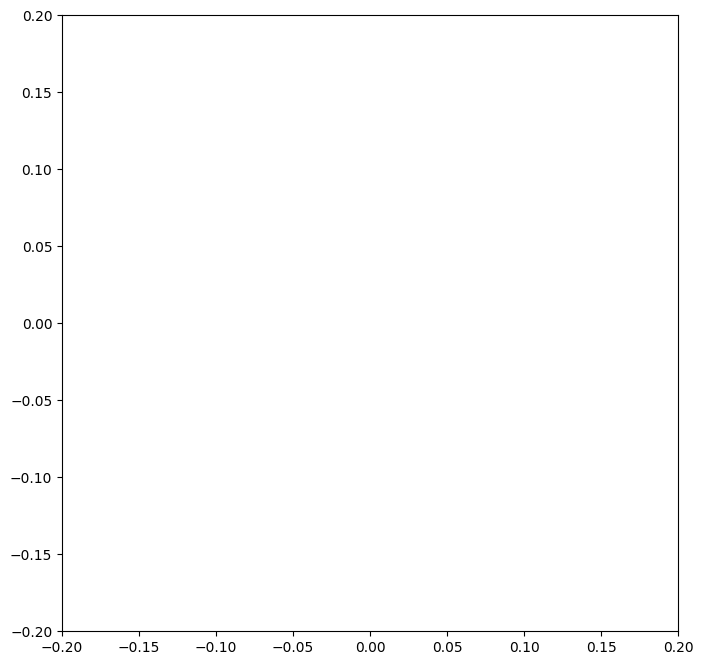

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Set up figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.set_aspect('equal')

# Pendulum elements
arm, = ax.plot([], [], 'b-', lw=2)
pendulum, = ax.plot([], [], 'r-', lw=2)

def animate(i):
    # Rotary arm position
    x_arm = Lr * np.cos(theta_vals[i])
    y_arm = Lr * np.sin(theta_vals[i])
    arm.set_data([0, x_arm], [0, y_arm])

    # Pendulum position
    x_pend = x_arm + Lp * np.sin(alpha_vals[i]) * np.cos(theta_vals[i])
    y_pend = y_arm + Lp * np.sin(alpha_vals[i]) * np.sin(theta_vals[i])
    pendulum.set_data([x_arm, x_pend], [y_arm, y_pend])

    return arm, pendulum

ani = FuncAnimation(fig, animate, frames=steps, interval=dt*1000, blit=False)
plt.show()